In [2]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.append("../")
sys.path.append("../../")

from models import BinaryRankingModel, WeibullModel
import batch_generators
import batch_generators_csr
from tools import test_quality 
from models import metabric_main_network

In [4]:
s = 1

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [5]:
with open('../../data/metabric.pkl', 'rb') as f:
    [
        (x_train, y_train),
        (x_test, y_test),
        (x_val, y_val)
    ] = pickle.load(f)

In [6]:
t_train = y_train[:, 0]
y_train = y_train[:, 1]

t_test = y_test[:, 0]
y_test = y_test[:, 1]

t_val = y_val[:, 0]
y_val = y_val[:, 1]

Set common parameters for learning

In [7]:
n_time_bins = 10
metabric_val_size = 30228
n_epochs = 30
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, x_train.shape[1])

#### Binary batch generator without sampling (using all available pairs)

In [26]:
graph_path = '../logs/graphs'
model_path = '../model/weibull_model'
batch_size = 1024
tf.reset_default_graph()
model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
saver = tf.train.Saver()

# validation data
dg = batch_generators.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=metabric_val_size, n_time_bins=n_time_bins)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

dg = batch_generators.BinaryDataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
print(n_batches)
hist_losses_train = []
all_pred = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
#     writer = tf.summary.FileWriter(graph_path, sess.graph)
    # for each epoch
    for i in tqdm(range(n_epochs)):
        # initialize generator
        gen = dg.get_batch()
        # for each batch
        for j in range(n_batches):
            # get batch data
            [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
            feed_dict = {
                model.x_a: x_batch_left, 
                model.x_b: x_batch_right, 
                model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                model.target: target.reshape((batch_size, 1)),
                model.sample_weight: sample_weight
            }
            # train model
            _, l = sess.run([train, model.loss], feed_dict=feed_dict)
        t_a, y_a, alphas_a, betas_a = sess.run([model.t_a, model.y_a, model.alphas_a, model.betas_a], feed_dict=feed_dict)
        print(np.mean(t_a, axis=0))
        print(np.sum(t_a, axis=0))
        print(np.mean(y_a, axis=0))
        print(np.sum(y_a, axis=0))
        print(np.mean(alphas_a, axis=0))
        print(np.sum(alphas_a, axis=0))
        print(np.mean(betas_a, axis=0))
        print(np.sum(betas_a, axis=0))
        t_a, y_a, alphas_a, betas_a = sess.run([model.t_b, model.y_b, model.alphas_b, model.betas_b], feed_dict=feed_dict)
        print(np.mean(t_a, axis=0))
        print(np.sum(t_a, axis=0))
        print(np.mean(y_a, axis=0))
        print(np.sum(y_a, axis=0))
        print(np.mean(alphas_a, axis=0))
        print(np.sum(alphas_a, axis=0))
        print(np.mean(betas_a, axis=0))
        print(np.sum(betas_a, axis=0))
        pred_1 = sess.run(model.o1, feed_dict={model.x_a: x_val})
        pred_2 = sess.run(model.o2, feed_dict={model.x_b: x_val})
        print(np.mean(pred_1, axis=0))
        print(np.mean(pred_2, axis=0))
        all_pred.append(pred_1)
        hist_losses_train.append(l)


516


[112.45348]
[115152.37]
[0.75683594]
[775.]
[210.9743]
[216037.69]
[2.026627]
[2075.266]
[113.34039]
[116060.56]
[0.75390625]
[772.]
[206.76439]
[211726.73]
[2.0148778]
[2063.2349]
[224.40904     2.0231266]
[223.76703     2.0220587]
[117.024376]
[119832.96]
[0.7548828]
[773.]
[145.00482]
[148484.94]
[1.899235]
[1944.8167]
[115.276985]
[118043.63]
[0.74316406]
[761.]
[145.20438]
[148689.28]
[1.895195]
[1940.6797]
[153.15366     1.9086692]
[154.22647     1.9066548]
[110.43711]
[113087.6]
[0.7451172]
[763.]
[145.1345]
[148617.73]
[1.7333193]
[1774.919]
[111.331345]
[114003.3]
[0.7548828]
[773.]
[146.56042]
[150077.88]
[1.7330441]
[1774.6372]
[153.88849     1.7753361]
[154.45938     1.7722156]
[112.25914]
[114953.36]
[0.7548828]
[773.]
[139.3076]
[142650.98]
[1.5577071]
[1595.092]
[115.162994]
[117926.91]
[0.76171875]
[780.]
[139.28018]
[142622.9]
[1.5445025]
[1581.5706]
[147.88945     1.5715458]
[149.50479     1.5686077]
[116.46791]
[119263.14]
[0.7675781]
[786.]
[142.10939]
[145520.02]
[

In [27]:
dg.ij_pos_sorted.shape

(2, 529045)

In [28]:
dg.ij_neg_sorted.shape

(2, 529879)

In [29]:
last_epoch_pred = all_pred[-1]

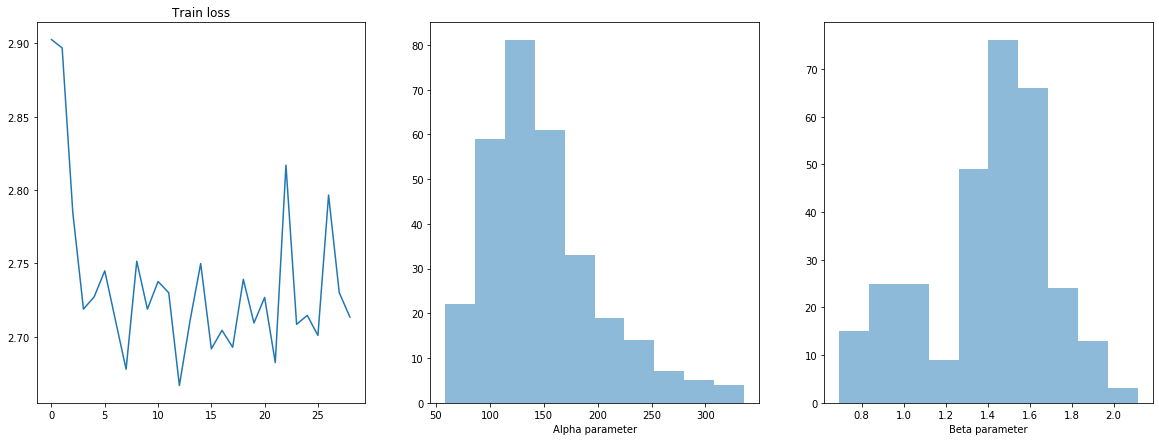

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

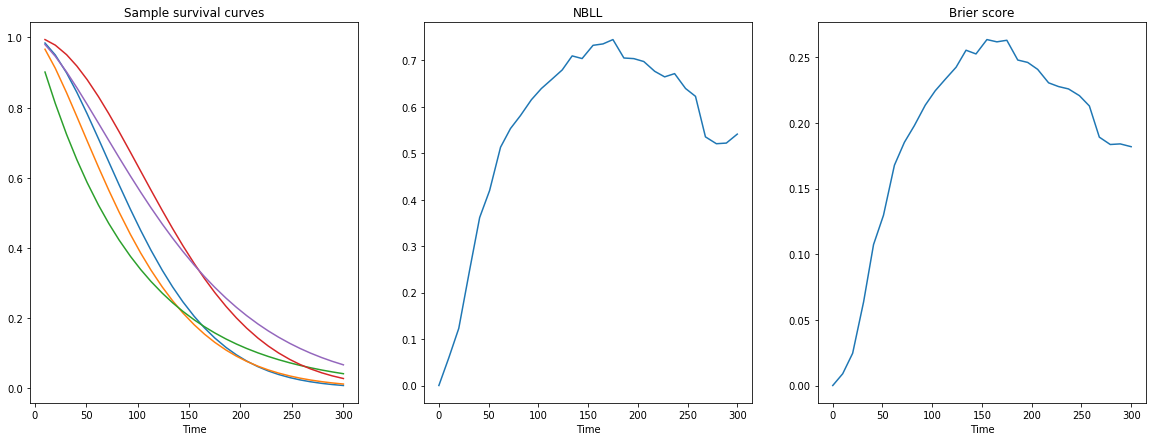

In [31]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103, plot=True)

In [32]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.623408,0.629462,0.193112,0.562661


#### Binary batch generator with sampling (using maximum pairs_per_sample = 300 pairs for each training example)

In [14]:
batch_size = 1024
pairs_per_sample = 1000

tf.reset_default_graph()
model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)

# validation data
dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
print(val_size)
dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=val_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

dg = batch_generators_csr.BinaryDataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
print("There are total {} batches".format(n_batches))

hist_losses_train = []
all_pred = []

with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm(range(n_epochs)):
        # initialize generator
        gen = dg.get_batch()
        # for each batch
        for j in range(n_batches):
            # get batch data
            [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
            feed_dict = {
                model.x_a: x_batch_left, 
                model.x_b: x_batch_right, 
                model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                model.target: target.reshape((batch_size, 1)),
                model.sample_weight: sample_weight
            }
            # train model
            _, l = sess.run([train, model.loss], feed_dict=feed_dict)
        pred_1 = sess.run(model.o1, feed_dict={model.x_a: x_val})
        all_pred.append(pred_1)
        hist_losses_train.append(l)


Initialization of batch generator...



Initialization of batch generator is completed
30137
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 451 batches


In [15]:
last_epoch_pred = all_pred[-1]

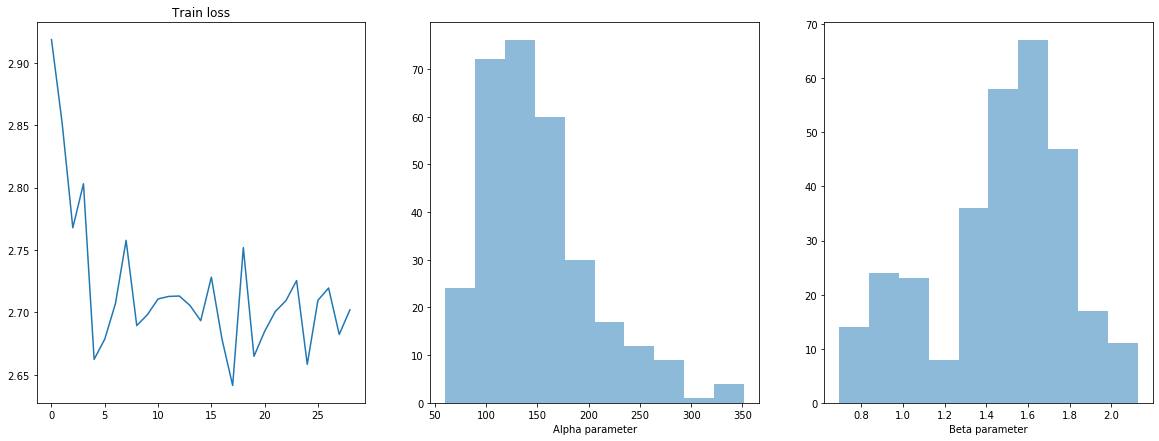

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

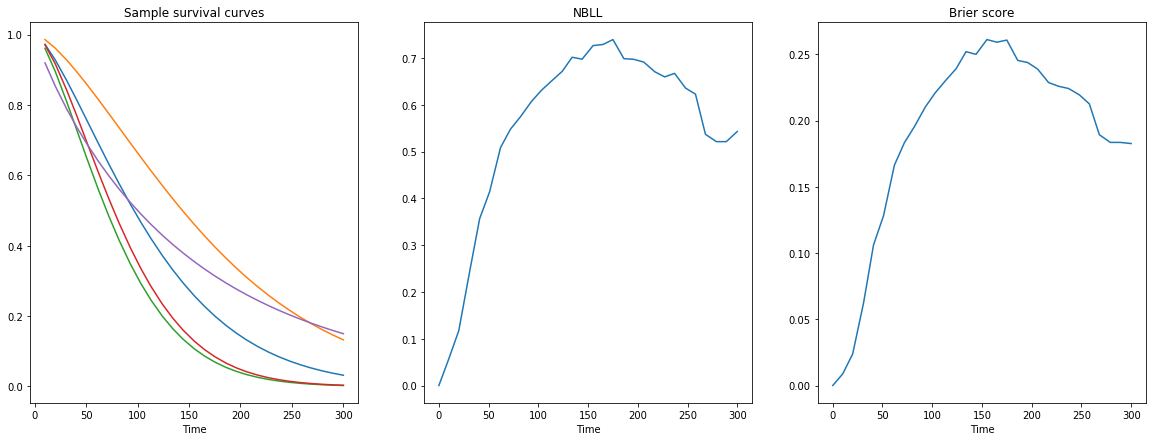

In [17]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103, plot=True)
q_weibull['pair_per_sample'] = pairs_per_sample

In [21]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill,pair_per_sample
0,0.620629,0.627179,0.191301,0.55799,1000


In [22]:
all_res = [q_weibull]

Initialization of batch generator...



Initialization of batch generator is completed
1100
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 4 batches


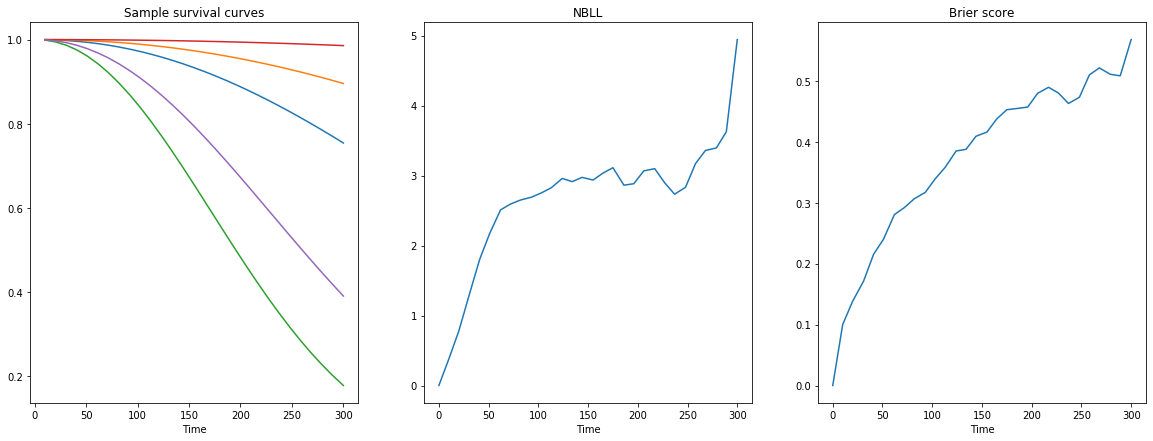

Initialization of batch generator...



Initialization of batch generator is completed
10770
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 45 batches


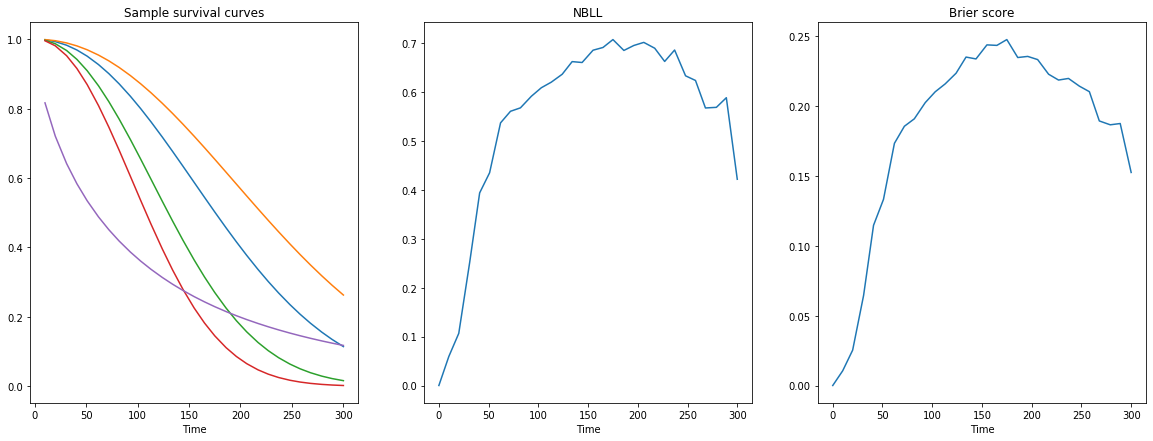

Initialization of batch generator...



Initialization of batch generator is completed
30137
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 227 batches


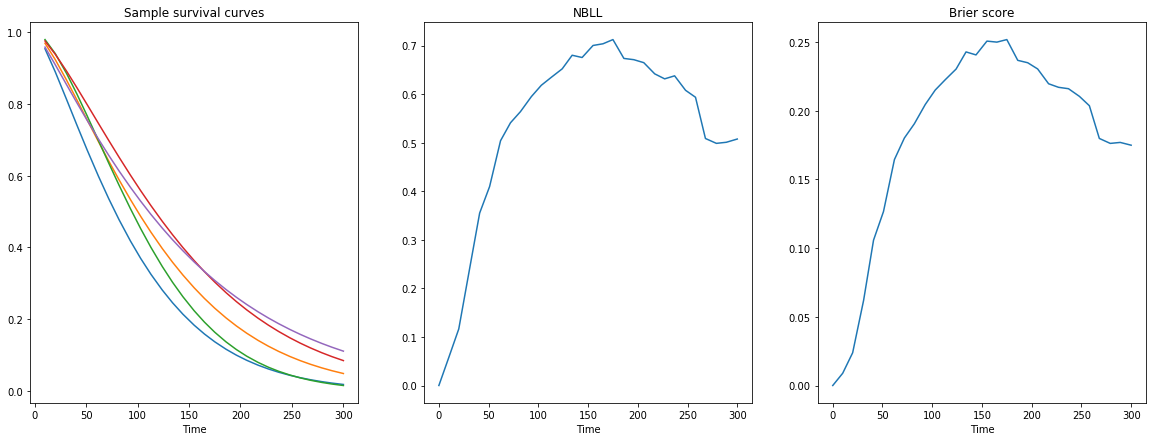

In [23]:
batch_size = 1024
for pairs_per_sample in tqdm([10, 100, 500]):

    tf.reset_default_graph()
    model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train = optimizer.minimize(model.loss)

    # validation data
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    print(val_size)
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=val_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

    dg = batch_generators_csr.BinaryDataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
    print("There are total {} batches".format(n_batches))

    hist_losses_train = []
    all_pred = []

    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            # for each batch
            for j in range(n_batches):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            pred_1 = sess.run(model.o1, feed_dict={model.x_a: x_val})
            all_pred.append(pred_1)
            hist_losses_train.append(l)
            
    q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=all_pred[-1], 
                 time_grid=time_grid, concordance_at_t=103, plot=True)
    q_weibull['pair_per_sample'] = pairs_per_sample
    all_res.append(q_weibull)

Initialization of batch generator...



Initialization of batch generator is completed
5321
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 22 batches


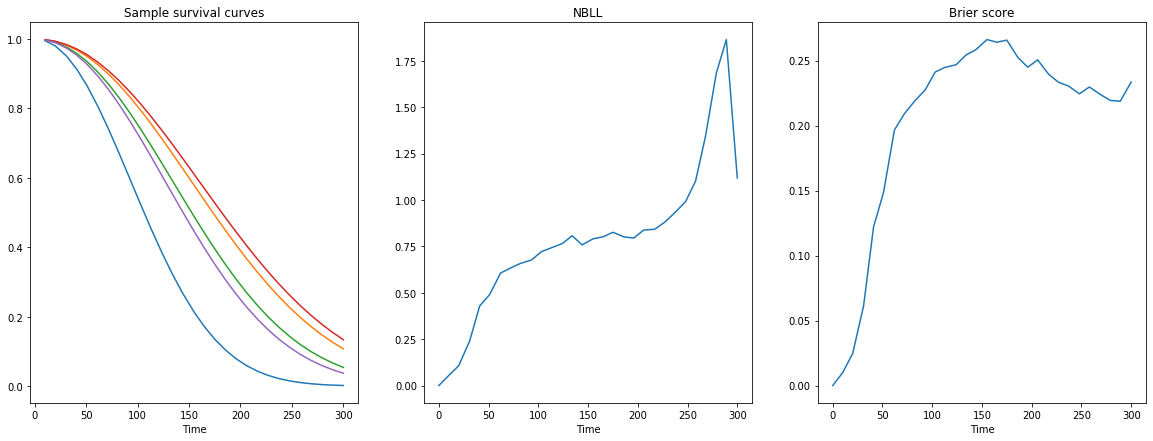

Initialization of batch generator...



Initialization of batch generator is completed
21375
Initialization of batch generator...



Initialization of batch generator is completed
Initialization of batch generator...



Initialization of batch generator is completed
There are total 91 batches


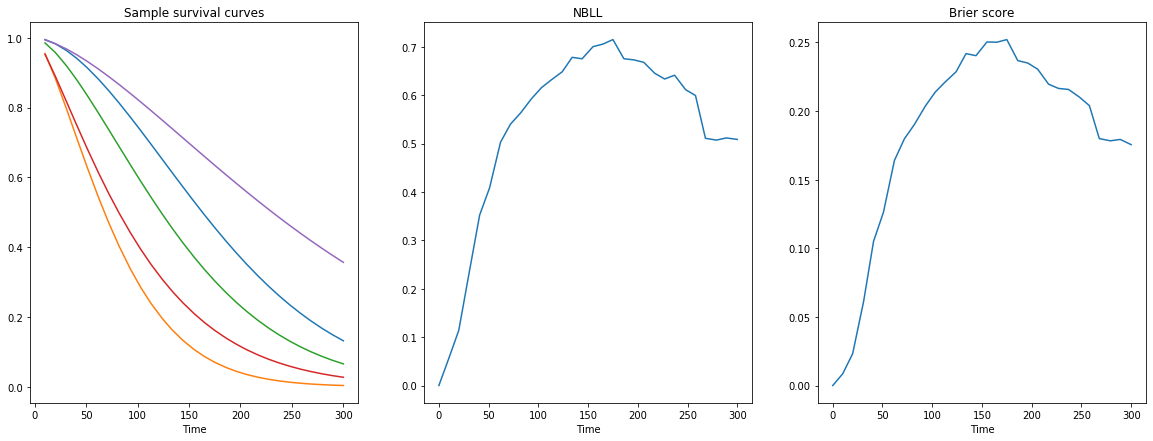

In [25]:
batch_size = 1024
for pairs_per_sample in tqdm([50, 200]):

    tf.reset_default_graph()
    model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train = optimizer.minimize(model.loss)

    # validation data
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    print(val_size)
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=val_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

    dg = batch_generators_csr.BinaryDataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
    print("There are total {} batches".format(n_batches))

    hist_losses_train = []
    all_pred = []

    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            # for each batch
            for j in range(n_batches):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            pred_1 = sess.run(model.o1, feed_dict={model.x_a: x_val})
            all_pred.append(pred_1)
            hist_losses_train.append(l)
            
    q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=all_pred[-1], 
                 time_grid=time_grid, concordance_at_t=103, plot=True)
    q_weibull['pair_per_sample'] = pairs_per_sample
    all_res.append(q_weibull)

#### Random sampling

In [ ]:
batch_size = 1024
all_res = []
for pairs_per_sample in tqdm([10, 50, 100, 200, 500]):

    tf.reset_default_graph()
    model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train = optimizer.minimize(model.loss)

    # validation data
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    print(val_size)
    dg = batch_generators_csr.BinaryDataGenerator(x=x_val, y=y_val, t=t_val, batch_size=val_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

    dg = batch_generators_csr.BinaryDataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins, pairs_per_sample=pairs_per_sample)
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
    print("There are total {} batches".format(n_batches))

    hist_losses_train = []
    all_pred = []

    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            # for each batch
            for j in range(n_batches):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            pred_1 = sess.run(model.o1, feed_dict={model.x_a: x_val})
            all_pred.append(pred_1)
            hist_losses_train.append(l)
            
    q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=all_pred[-1], 
                 time_grid=time_grid, concordance_at_t=103, plot=False)
    q_weibull['pair_per_sample'] = pairs_per_sample
    all_res.append(q_weibull)

In [30]:
df_result = pd.concat(all_res)
df_result.sort_values('pair_per_sample', inplace=True)
df_result

,harell_c_index,dt_c_index,int_brier_score,int_nbill,pair_per_sample
0,0.494095,0.482748,0.375649,2.651291,10
0,0.579940,0.565318,0.205183,0.788336,50
0,0.610209,0.599193,0.185785,0.555262,100
0,0.627212,0.632604,0.184744,0.540778,200
0,0.624665,0.631380,0.185006,0.540035,500
0,0.620629,0.627179,0.191301,0.557990,1000


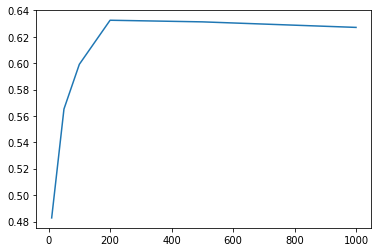

In [31]:
plt.plot(df_result['pair_per_sample'].values, df_result['dt_c_index'].values)

### Online batch hard mining 

In [8]:
from models_hard_mining import WeibullModel
from batch_generators_hard_mining import ContrastiveDataGenerator

In [34]:
## select n_ex_bin for validation data
start_n_ex_bin = round(x_val.shape[0] / n_time_bins)

def check_n_ex_val(n_ex_bin):
    dg = ContrastiveDataGenerator(x=x_val, y=y_val, t=t_val, n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)
    x_batch, y_batch_val, sample_weight_val, target_val = next(dg.get_batch()) 
    
for i in range(start_n_ex_bin, 0, -1):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  30
Max n_ex_bin:  29


#### Weibull Model

In [53]:
n_ex_bin = 3
n_epochs = 200

In [60]:
# graph_path = '../logs/graphs'
# model_path = '../model/weibull_model'
# batch_size = 1024
tf.reset_default_graph()
model = WeibullModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network, alpha_reg=1e-3)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
# saver = tf.train.Saver()

# validation data
dg = ContrastiveDataGenerator(x=x_val, y=y_val, t=t_val, n_ex_bin=29, n_time_bins=n_time_bins)
x_batch, y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

dg = ContrastiveDataGenerator(x=x_train, y=y_train, t=t_train, n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)

hist_losses_train = []
all_pred = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
#     writer = tf.summary.FileWriter(graph_path, sess.graph)
    # for each epoch
    for i in tqdm(range(n_epochs)):
        # initialize generator
        gen = dg.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            except StopIteration:
                break
        t_a, y_a, alphas_a, betas_a = sess.run([model.t, model.y, model.alphas, model.betas], feed_dict=feed_dict)
        pred_1 = sess.run(model.o1, feed_dict={model.x: x_val})
        all_pred.append(pred_1)
        hist_losses_train.append(l)


In [65]:
last_epoch_pred = all_pred[-1]

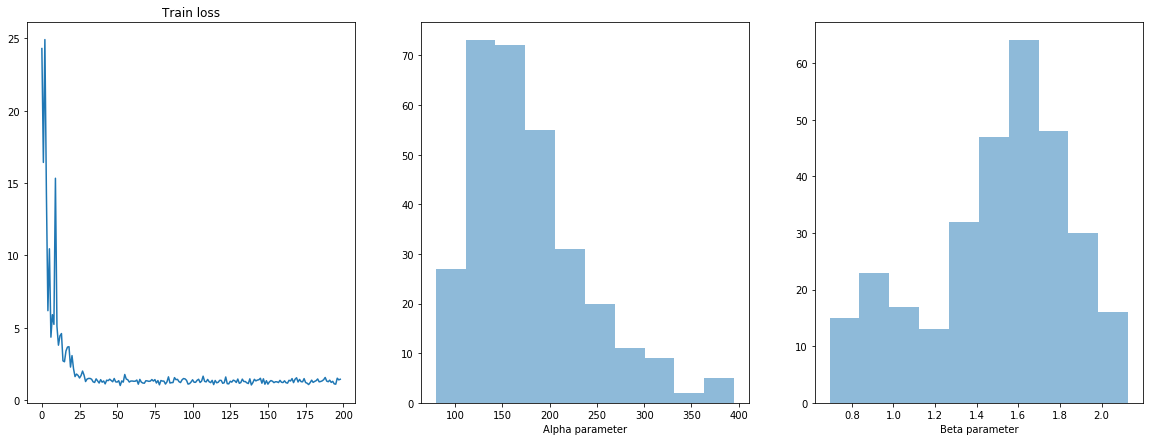

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

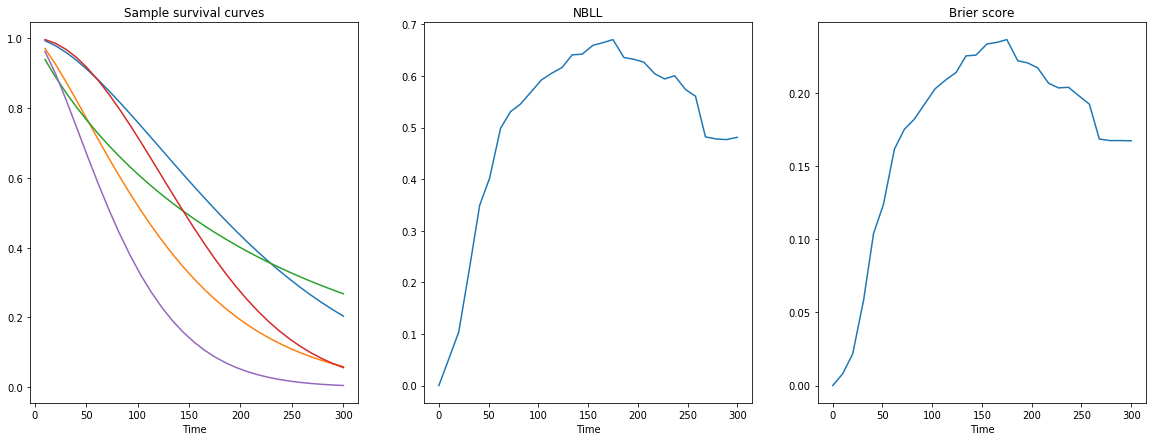

In [67]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103, plot=True)

In [68]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.627345,0.630123,0.174931,0.513512


#### Contrastive Weibull Model

In [10]:
from models_hard_mining import WeibullModel, ContrastiveRankingModel
from batch_generators_hard_mining import ContrastiveDataGenerator

In [11]:
n_ex_bin = 3
n_epochs = 400

In [13]:
tf.reset_default_graph()
model = ContrastiveRankingModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network, alpha_reg=1e-3, contrastive_weight=1, margin_weight=1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
train = optimizer.minimize(model.loss)


# validation data
dg = ContrastiveDataGenerator(x=x_val, y=y_val, t=t_val, n_ex_bin=29, n_time_bins=n_time_bins)
x_batch, y_batch_val, target_val = next(dg.get_batch())

dg = ContrastiveDataGenerator(x=x_train, y=y_train, t=t_train, n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)

hist_losses_train = []
all_pred = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm(range(n_epochs)):
        # initialize generator
        gen = dg.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            except StopIteration:
                break
        t_a, y_a, alphas_a, betas_a = sess.run([model.t, model.y, model.alphas, model.betas], feed_dict=feed_dict)
        pred_1 = sess.run(model.o1, feed_dict={model.x: x_val})
        all_pred.append(pred_1)
        hist_losses_train.append(l)


In [14]:
last_epoch_pred = all_pred[-1]

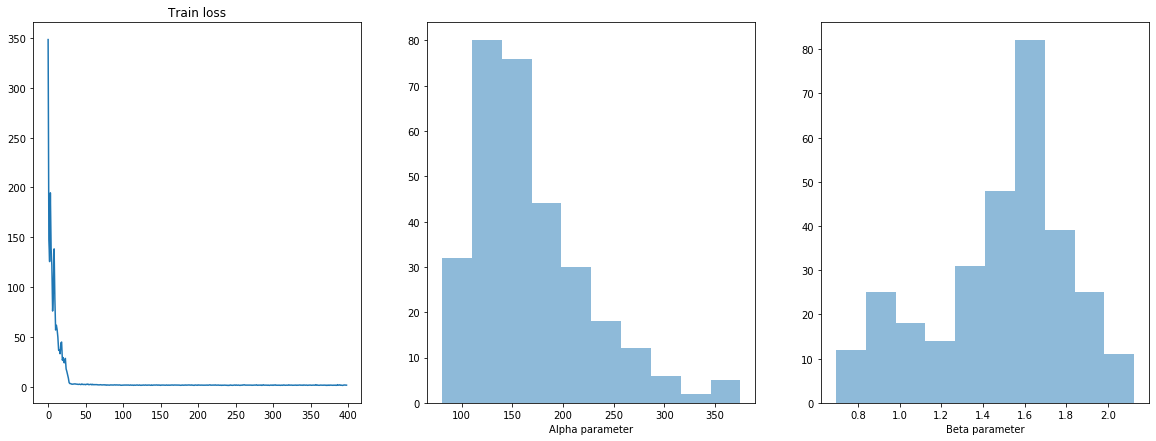

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

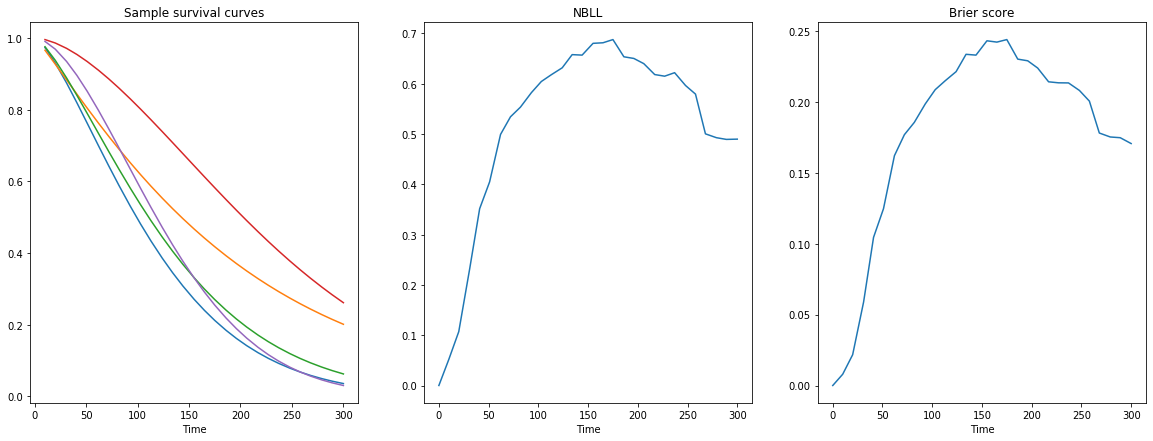

In [16]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103, plot=True)

In [17]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.628932,0.640842,0.180293,0.525892


#### Binary Weibull Model

In [11]:
from models_hard_mining import BinaryRankingModel
from batch_generators_hard_mining import ContrastiveDataGenerator

In [12]:
n_ex_bin = 3
n_epochs = 400

In [13]:
tf.reset_default_graph()
model = BinaryRankingModel(input_shape=inp_shape, seed=s, main_network=metabric_main_network, alpha_reg=1e-3)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
train = optimizer.minimize(model.loss)

# validation data
dg = ContrastiveDataGenerator(x=x_val, y=y_val, t=t_val, n_ex_bin=29, n_time_bins=n_time_bins)
x_batch, y_batch_val, target_val = next(dg.get_batch())

dg = ContrastiveDataGenerator(x=x_train, y=y_train, t=t_train, n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)

hist_losses_train = []
all_pred = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm(range(n_epochs)):
        # initialize generator
        gen = dg.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            except StopIteration:
                break
        t_a, y_a, alphas_a, betas_a = sess.run([model.t, model.y, model.alphas, model.betas], feed_dict=feed_dict)
        pred_1 = sess.run(model.o1, feed_dict={model.x: x_val})
        all_pred.append(pred_1)
        hist_losses_train.append(l)


In [14]:
last_epoch_pred = all_pred[-1]

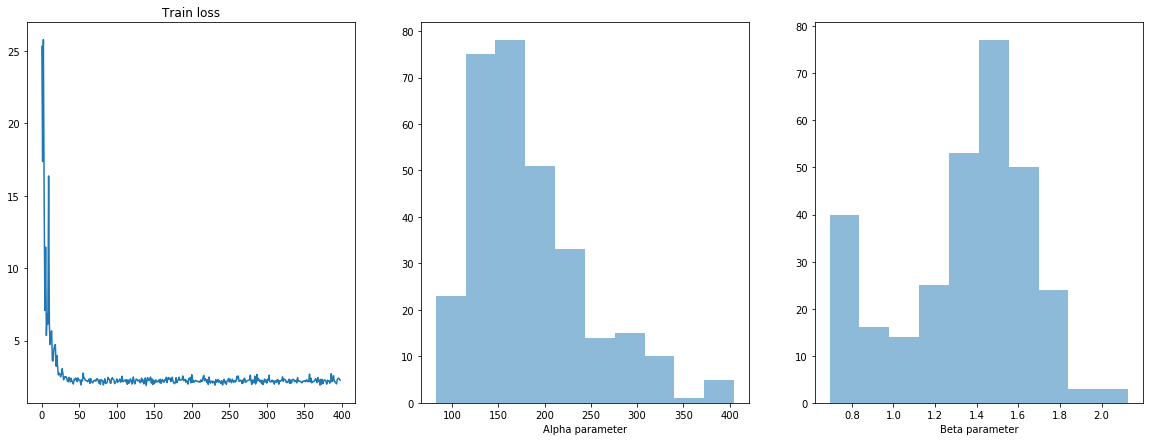

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

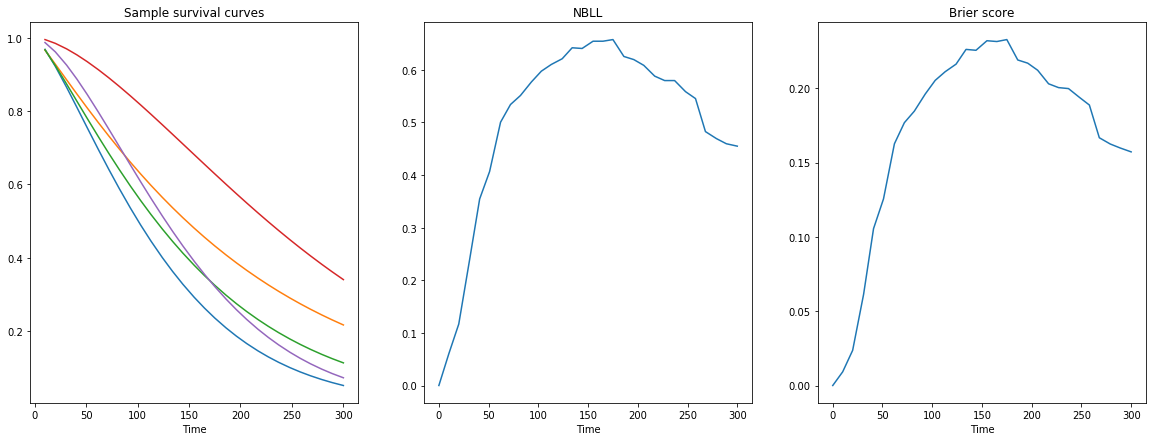

In [16]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103, plot=True)

In [17]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.627113,0.632935,0.17348,0.509296


In [ ]:
# for metabric eval at every epoch - select number of epochs and then try to change estimator

In [8]:
from models import metabric_main_network
from train import train, initialize_model
from tools import test_quality 

In [9]:
def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
#     ax[0].axvline(n_epochs[0], c='black', linestyle='--')
#     ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
#     ax[0].axvline(n_epochs[0], c='black', linestyle='--')
#     ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
#     ax[1].axvline(n_epochs[0], c='black', linestyle='--')
#     ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
#     ax[2].axvline(n_epochs[0], c='black', linestyle='--')
#     ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
#     ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
#     ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
#     ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


##### Load METABRIC data

In [44]:
with open('../../data/metabric.pkl', 'rb') as f:
    [
        (x_train, y_train),
        (x_test, y_test),
        (x_val, y_val)
    ] = pickle.load(f)

t_train = y_train[:, 0]
y_train = y_train[:, 1]

t_test = y_test[:, 0]
y_test = y_test[:, 1]

t_val = y_val[:, 0]
y_val = y_val[:, 1]

data = dict()

data['train'] = {
    'x': x_train,
    't': t_train,
    'y': y_train
}
data['test'] = {
    'x': x_test,
    't': t_test,
    'y': y_test
}
data['val'] = {
    'x': x_val,
    't': t_val,
    'y': y_val
}

In [18]:
args = {
    'verbose': 0,
    'save_model': False,
    'save_path': '../../models/',
    'model_type': 'metabric_test'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    "alpha_bias_random_mean": 0,
    "alpha_random_stddev": 1,
    "beta_random_stddev": 1,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 3,
    'val_n_ex_bin': 300,
    
    'n_epochs': 200,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001
}

In [19]:
s = 1

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 200/200 [01:44<00:00,  1.92it/s]

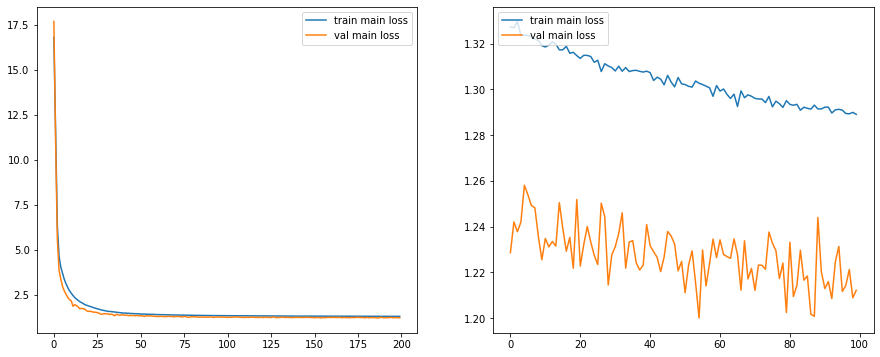

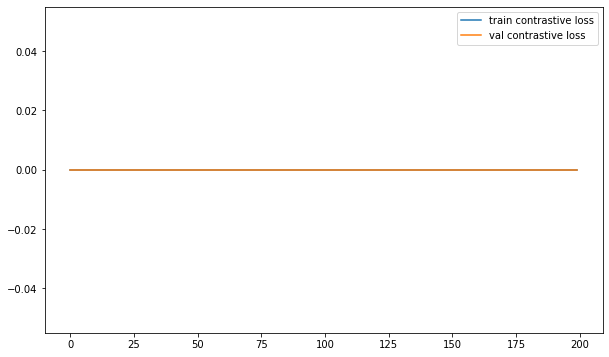

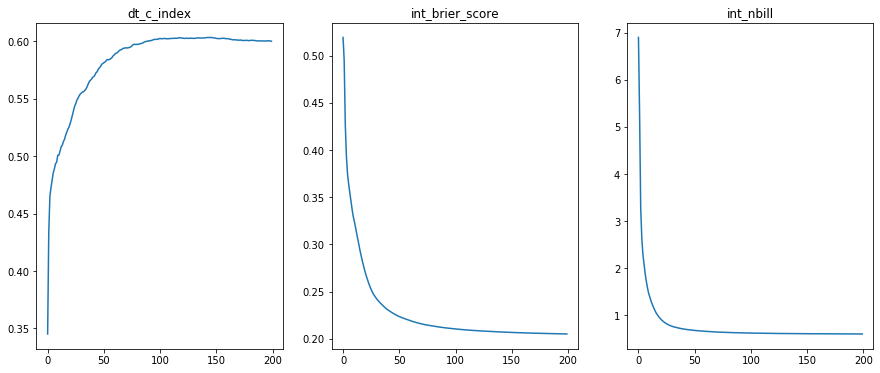

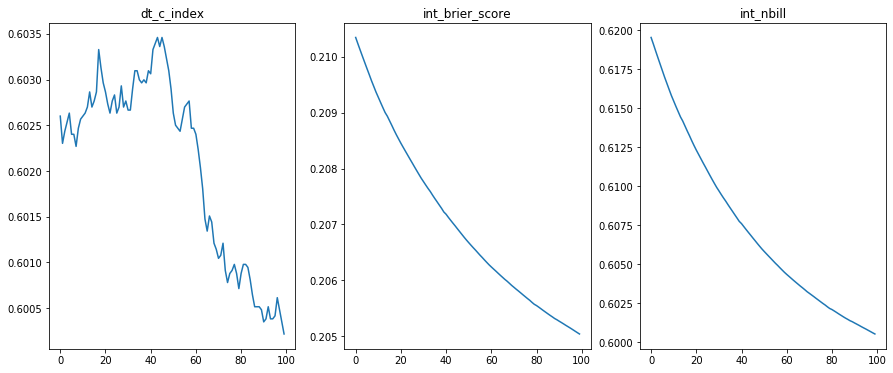

In [20]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='base', train_data=data['train'], config=config, custom_bottom=metabric_main_network, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train(
    args=args, train_data=data['train'], val_data=data['val'], config=config, data_gen=data_gen, model=model, seed=config['seed'], optimizer='sgd'
)

all_q = []
for pred in all_pred_val:
    all_q.append(
        test_quality(
            t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False
        )
    )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, n_epochs=[config['n_epochs'], 0, 0])

In [28]:
# n_epochs 200 -> 400

In [29]:
args = {
    'verbose': 0,
    'save_model': False,
    'save_path': '../../models/',
    'model_type': 'metabric_test'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    "alpha_bias_random_mean": 0,
    "alpha_random_stddev": 1,
    "beta_random_stddev": 1,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 3,
    'val_n_ex_bin': 300,
    
    'n_epochs': 400,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001
}

In [30]:
s = 1

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

100%|██████████| 400/400 [03:29<00:00,  1.91it/s]


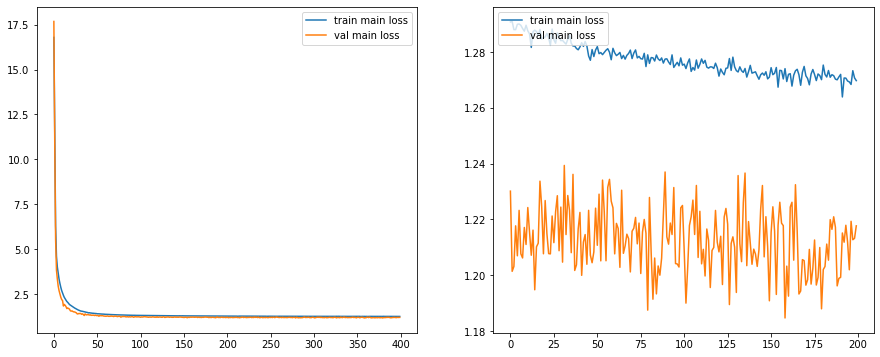

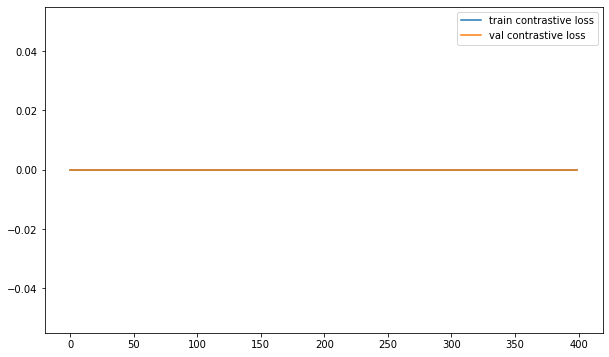

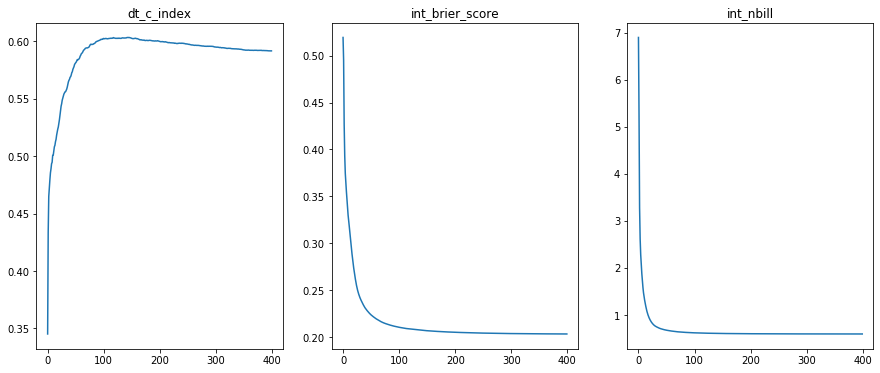

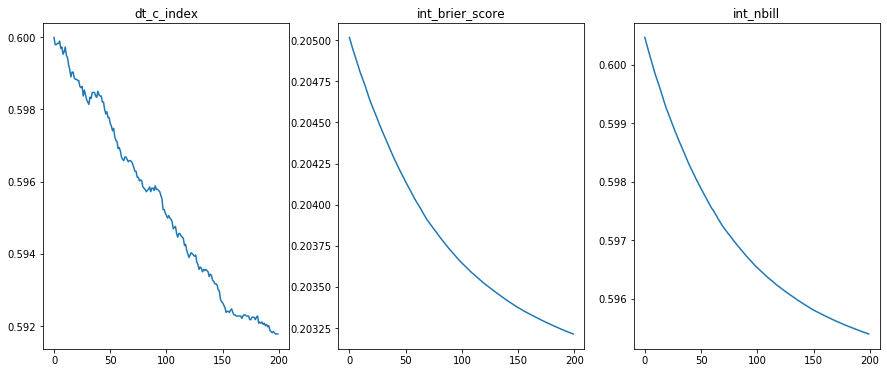

In [31]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='base', train_data=data['train'], config=config, custom_bottom=metabric_main_network, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train(
    args=args, train_data=data['train'], val_data=data['val'], config=config, data_gen=data_gen, model=model, seed=config['seed'], optimizer='sgd'
)

all_q = []
for pred in all_pred_val:
    all_q.append(
        test_quality(
            t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False
        )
    )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, n_epochs=[config['n_epochs'], 0, 0])

In [33]:
df_all_q = df_all_q.reset_index()

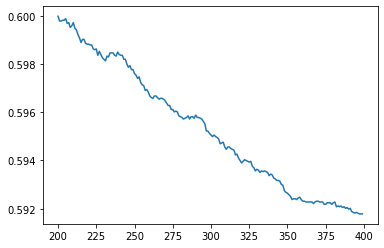

In [34]:
plt.plot(df_all_q[-200:]['dt_c_index'])

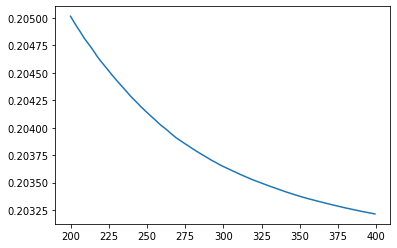

In [35]:
plt.plot(df_all_q[-200:]['int_brier_score'])

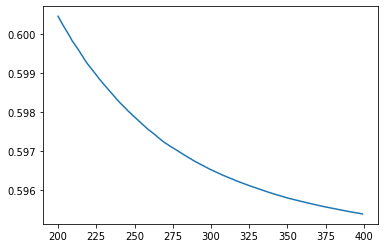

In [36]:
plt.plot(df_all_q[-200:]['int_nbill'])

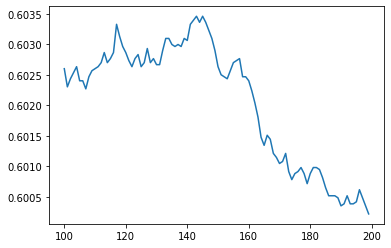

In [38]:
plt.plot(df_all_q[100:200]['dt_c_index'])

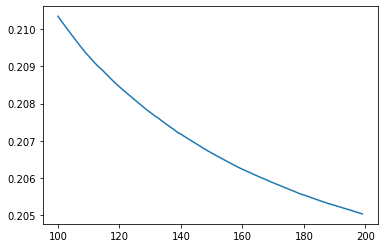

In [39]:
plt.plot(df_all_q[100:200]['int_brier_score'])

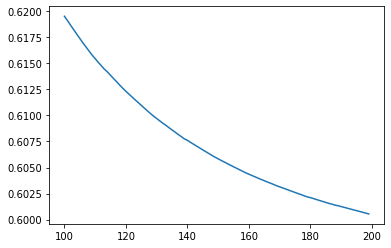

In [40]:
plt.plot(df_all_q[100:200]['int_nbill'])

In [ ]:
# fix 200 epochs 
# ? optimal estimator sgd -> adam

In [41]:
args = {
    'verbose': 0,
    'save_model': False,
    'save_path': '../../models/',
    'model_type': 'metabric_test'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    "alpha_bias_random_mean": 0,
    "alpha_random_stddev": 1,
    "beta_random_stddev": 1,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 3,
    'val_n_ex_bin': 300,
    
    'n_epochs': 200,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001
}

In [42]:
s = 1

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


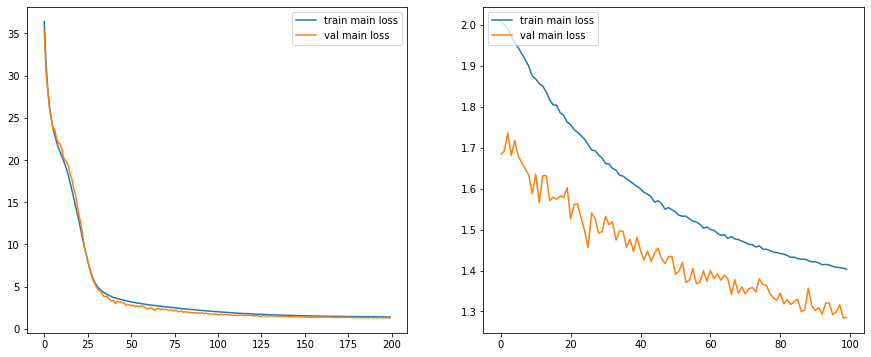

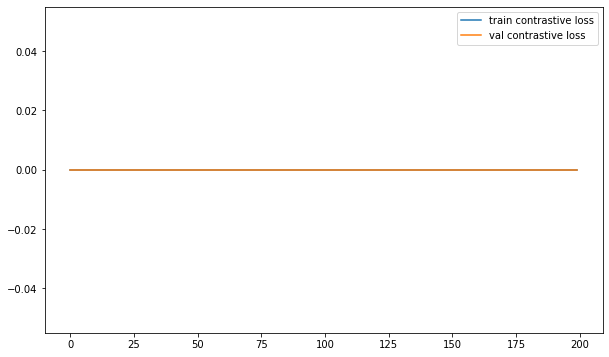

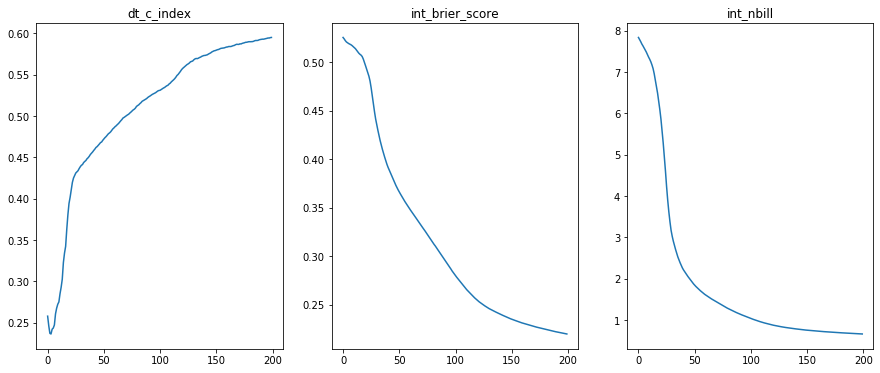

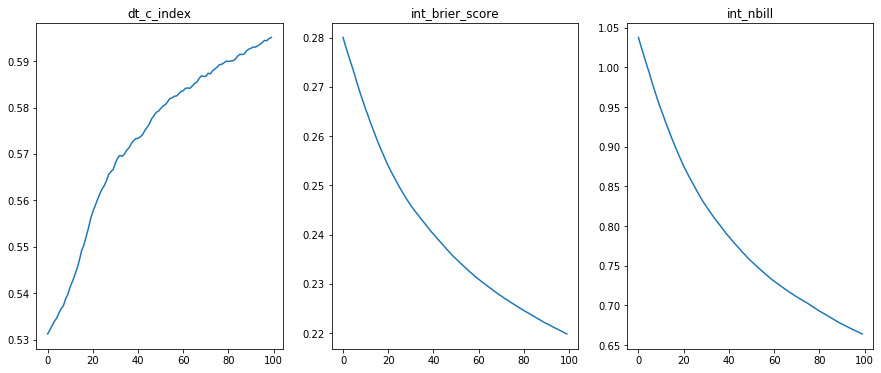

In [43]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='base', train_data=data['train'], config=config, custom_bottom=metabric_main_network, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train(
    args=args, train_data=data['train'], val_data=data['val'], config=config, data_gen=data_gen, model=model, seed=config['seed'], optimizer='adam'
)

all_q = []
for pred in all_pred_val:
    all_q.append(
        test_quality(
            t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False
        )
    )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, n_epochs=[config['n_epochs'], 0, 0])